# Beach Trash Detector - Final Project

**Description**: Life at the oceans is not as safe as it used to be before human kind started to polute the oceans, beaches and seas. The garbage throw at the beach, usually ends in the ocean and it is harmful to all animals and the enviroment, with that in mind my idea is to develop a computer vision software to recognize trash at the beach, and with the help of a drone recognize this trash and save its locations, so that someone can pickup, or another drones could do that job, why not.



In [14]:
import json

DATASET_PATH = 'dataset/'
ANNOTATIONS_JSON = 'annotations.json'
with open(DATASET_PATH + ANNOTATIONS_JSON, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
annotations = dataset['annotations']
images = dataset['images']
print(f'categories: {len(categories)}\nannotations: {len(annotations)}\nimages: {len(images)}')

categories: 60
annotations: 4784
images: 1500


In [15]:
with open('dataset/annotations_0_test.json', 'r') as f:
    d = json.loads(f.read())
images = [i['file_name'] for i in d['images']]
print(len(images))

15


In [16]:
from pycocotools.coco import COCO

c = COCO(annotation_file='dataset/annotations.json')

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!


In [17]:
a_0 = c.anns[1]
img = c.imgToAnns[3]
segmentations = []
for i in img:
    x = []
    y = []
    for j, k in enumerate(i['segmentation'][0]):
        if j % 2 ==0:
            x.append(k)
        else:
            y.append(k)
    segmentations.append({'all_x': x, 'all_y': y})
        
#     segmentations += i['segmentation']
print(len(segmentations))


# print(imgs[0][0]['segmentation'])
# [img for img in imgs if img['segmentation']]

4


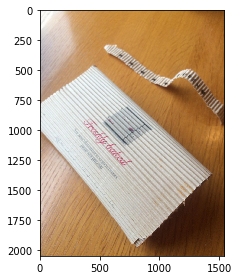

In [18]:
import skimage.io
image = skimage.io.imread("dataset/batch_1/000008.jpg")
skimage.io.imshow(image)

In [19]:
import os
from mrcnn.utils import Dataset
from mrcnn import visualize

class TrashDataset(Dataset):
    def load_dataset(self, dataset_dir, is_train=True):
        # define one class
        self.add_class("dataset", 1, "trash")
        # define data locations
        # find all images
        imgs = list(c.imgToAnns.values())
        if is_train:
            imgs = imgs[:100]
        else:
            imgs = imgs[100:]
        for img in imgs:
            # extract image id
            image_id = img[0]['image_id']
            image_data = c.loadImgs([image_id])[0]
            segmentations = []
            for i in img:
                x = []
                y = []
                for j, k in enumerate(i['segmentation'][0]):
                    if j % 2 ==0:
                        x.append(k)
                    else:
                        y.append(k)
                segmentations.append({'all_points_x': x, 'all_points_y': y})

            image_path = dataset_dir + image_data['file_name']
            height = image_data['height']
            width = image_data['width']
            self.add_image(
                "dataset",
                image_id=image_data['file_name'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=segmentations)
            
    def load_mask(self, image_id):
        """Generate instance masks for an image.
            Returns:
            masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "dataset":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask, np.ones([mask.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "database":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [20]:
dataset = TrashDataset()
dataset.load_dataset(DATASET_PATH, is_train=True)
dataset.prepare()

In [21]:
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 100
Class Count: 2
  0. BG                                                
  1. trash                                             


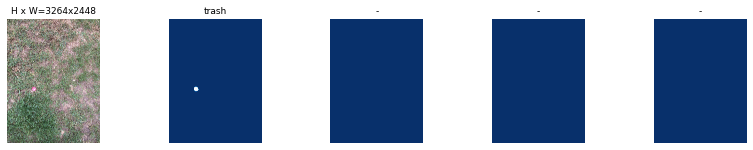

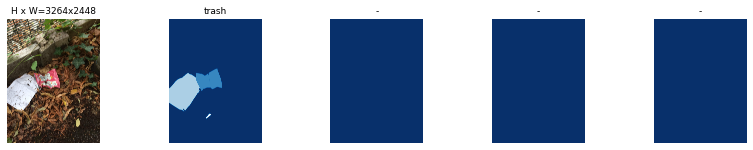

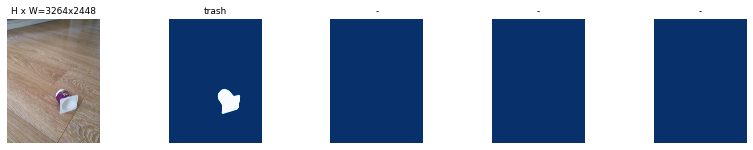

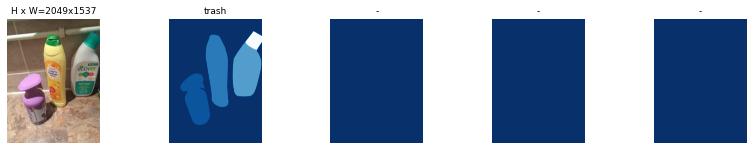

In [22]:
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  75 None


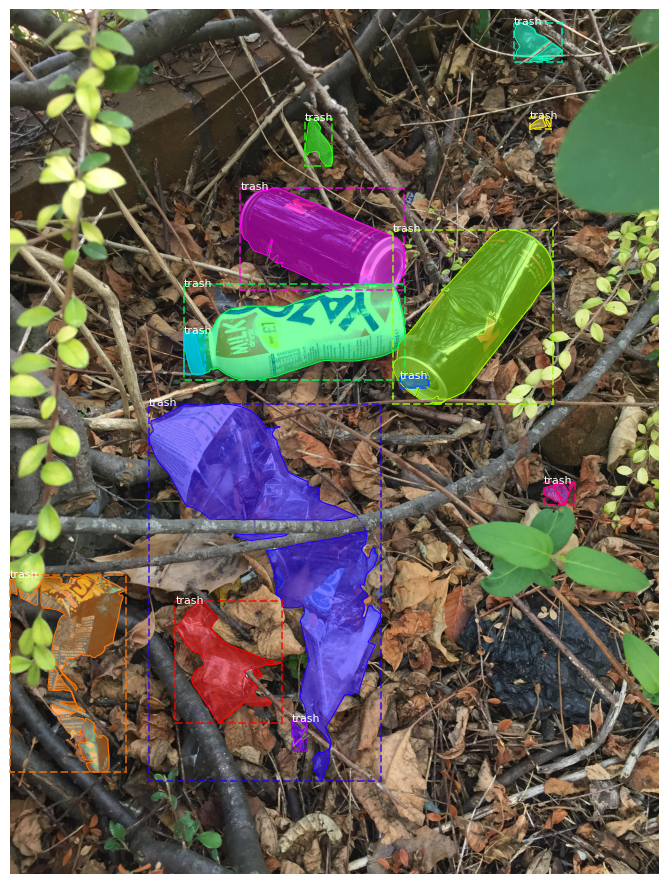

In [23]:
from mrcnn.utils import extract_bboxes

image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))

# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [24]:
from mrcnn.config import Config

config = Config()
config.NAME = "TrashConfig"
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                13
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [25]:
from mrcnn.utils import download_trained_weights

COCO_MODEL_PATH = 'dataset/mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    download_trained_weights(COCO_MODEL_PATH)


In [26]:
from mrcnn import model as modellib
# Create model object in inference mode.
MODEL_DIR = 'model/'
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

ValueError: Tried to convert 'shape' to a tensor and failed. Error: None values not supported.

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 3.21 MiB/s, done.
Resolving deltas: 100% (566/566), done.


TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 6 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'

